In [1]:
import uproot
import matplotlib.pyplot as plt 
import mplhep as hep
import numpy as np
import fnmatch
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from tqdm import tqdm
import hist
import pickle as pkl
import pandas as pd

In [3]:
hists = uproot.open("/grid/fermiapp/products/sbnd/sbnd_data/v01_22_00/ParticleGunHists/particlegun_bnb_hists.root")

idx_u0 = 0 
idx_v0 = 1984
idx_w0 = 3968
idx_u1 = 5632
idx_v1 = 7616
idx_w1 = 9000

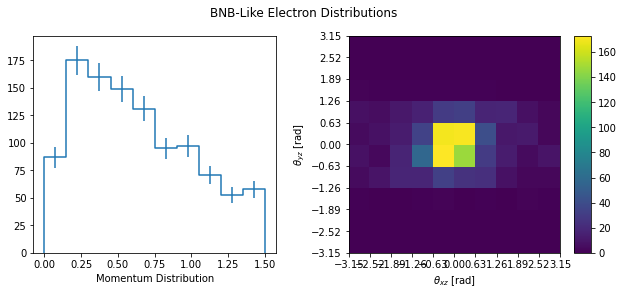

In [8]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
hep.histplot(hists['hPHist_electrons'],ax=axes[0])
axes[0].set_xlabel("Momentum Distribution")
axes[1].set_xlabel(r"$\theta_{xz}$ [rad]")
axes[1].set_ylabel(r"$\theta_{yz}$ [rad]")
hep.hist2dplot(hists['hThetaXzYzHist_electrons'],ax=axes[1])
plt.suptitle("BNB-Like Electron Distributions")
plt.show()

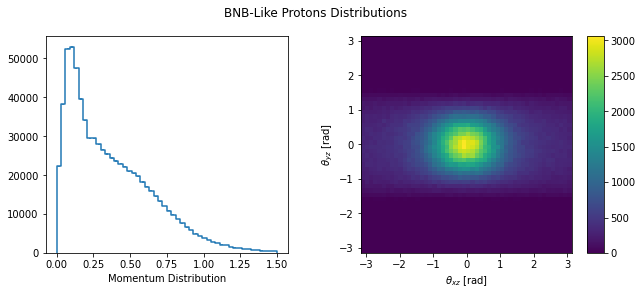

In [9]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
plt.subplots_adjust(wspace=0.3)
hep.histplot(hists['hPHist_protons'],ax=axes[0])
axes[0].set_xlabel("Momentum Distribution")
axes[1].set_xlabel(r"$\theta_{xz}$ [rad]")
axes[1].set_ylabel(r"$\theta_{yz}$ [rad]")
hep.hist2dplot(hists['hThetaXzYzHist_protons'],ax=axes[1])
plt.suptitle("BNB-Like Protons Distributions")
plt.show()

## Methodology

- protons:
    - sim channel: peak finding, integrate over whole peak (no gauss fitting). If peaks are very close, combine into a single peak 
    - decon wvfm: peak finding, integrate over whole peak 
- electrons:
    - sim channel: integrate over whole channel
    - decon wvfm: integrate over whole channel

current ch sum threshold (determine if a sim channel has any signal at all) = 100? 

peak threshold = 800 e-

In [3]:
range()

range(50, 100, 10)

In [4]:
def find_nonzero_ch(wvfm):
    # peak threshold = 800
    mask = (wvfm > 800).sum(axis = 1)
    return np.where(mask>0)[0]
    
def gauss(x,a,mu,sigma):
    return a*np.exp(-0.5*((x-mu)/sigma)**2)

def get_gauss(wvfm, peaks:np.ndarray, pdict:dict):
    # wvfm is dec, or sim hists
    # will return a list of arrays, with len equal to the number of peaks
    x_out = []; y_out = []
    xvals = np.linspace(0,len(wvfm),len(wvfm))
    for i in range(len(peaks)):
        idx = i 
        x0 = xvals[pdict['left_bases'][idx]:pdict['right_bases'][idx]]
        y0 = wvfm[pdict['left_bases'][idx]:pdict['right_bases'][idx]]
        if len(x0)<3: 
            print("can't perform a fit with only ", len(x0), "values")
            x_out.append(x0)
            y_out.append(np.zeros(len(x0)))
        else: 
            popt, pcov = curve_fit(gauss, x0, y0, p0 = [pdict['peak_heights'][idx],peaks[idx],0.5*pdict['widths'][idx]])
            x_out.append(x0)
            y_out.append(gauss(x0,*popt))
    return x_out, y_out

def u_ch(input): 
    tpc0_arr = input[0     :idx_v0]
    tpc1_arr = input[idx_u1:idx_v1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def v_ch(input): 
    tpc0_arr = input[idx_v0:idx_w0]
    tpc1_arr = input[idx_v1:idx_w1]
    return np.concatenate([tpc0_arr,tpc1_arr])

def w_ch(input): 
    tpc0_arr = input[idx_w0:idx_u1]
    tpc1_arr = input[idx_w1:]
    return np.concatenate([tpc0_arr,tpc1_arr])

def find_u_ch(ch_num):
    if (((ch_num >= 0 ) & (ch_num < idx_v0)) | ((ch_num >= idx_u1) & (ch_num < idx_v1))):
        return True
    else:
        return False
    
def find_v_ch(ch_num):
    if (((ch_num >= idx_v0 ) & (ch_num < idx_w0)) | ((ch_num >= idx_v1) & (ch_num < idx_w1))):
        return True
    else:
        return False

def find_w_ch(ch_num):
    if (((ch_num >= idx_w0 ) & (ch_num < idx_u1)) | ((ch_num >= idx_w1))):
        return True
    else:
        return False


## Proton

In [5]:
proton_file = uproot.open("/sbnd/data/users/lynnt/v09_75_03/ana_waveform_9.root:wvfm")
proton_tree = uproot.open( "/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/proton_caf/ana_caf.root:recTree" )
proton_caf = proton_tree.arrays([ "rec.mc.nu.prim.startp.x" ,
                             "rec.mc.nu.prim.startp.y",
                             "rec.mc.nu.prim.startp.z",
                             "rec.mc.nu.prim.startE",
                             "rec.mc.nu.prim.endE"],library='pd')
proton_caf["theta_xz"] = np.arctan(abs(proton_caf["rec.mc.nu.prim.startp.x"])/abs(proton_caf["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
proton_caf["theta_yz"] = np.arctan(proton_caf["rec.mc.nu.prim.startp.z"]/proton_caf["rec.mc.nu.prim.startp.y"])*(180/np.pi)
proton_caf["depE"] = proton_caf["rec.mc.nu.prim.startE"] - proton_caf["rec.mc.nu.prim.endE"]
proton_caf["startp"] = np.sqrt(proton_caf["rec.mc.nu.prim.startp.y"]**2 + proton_caf["rec.mc.nu.prim.startp.x"]**2 + proton_caf["rec.mc.nu.prim.startp.z"]**2)

In [31]:
# proton_caf["v_py"] = proton_caf.startp*np.cos((proton_caf.theta_yz - 60)*(np.pi/180))
# proton_caf["u_py"] = proton_caf.startp*np.cos((proton_caf.theta_yz + 60)*(np.pi/180))
proton_caf["v_pz"] = proton_caf.startp*np.sin((proton_caf.theta_yz - 60)*(np.pi/180)) # change units inside sin from degree to rad
proton_caf["u_pz"] = proton_caf.startp*np.sin((proton_caf.theta_yz + 60)*(np.pi/180)) # change units inside sin from degree to rad

proton_caf["u_theta_xz"] = (np.arctan((proton_caf["rec.mc.nu.prim.startp.x"])/(proton_caf["u_pz"]))*(180/np.pi))
proton_caf["v_theta_xz"] = (np.arctan((proton_caf["rec.mc.nu.prim.startp.x"])/(proton_caf["v_pz"]))*(180/np.pi))

(array([30., 30., 20., 20., 10., 10., 10., 50., 10., 10.]),
 array([-65.69385 , -50.723885, -35.753918, -20.783955,  -5.813989,
          9.155975,  24.12594 ,  39.095905,  54.06587 ,  69.035835,
         84.0058  ], dtype=float32),
 <BarContainer object of 10 artists>)

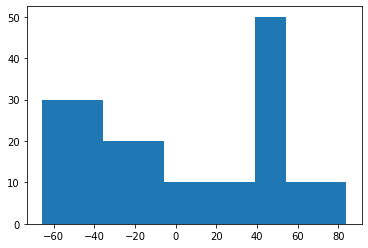

In [32]:
plt.hist(proton_caf["u_theta_xz"])

(array([30., 10., 30., 40., 10., 20.,  0., 20., 30., 10.]),
 array([-84.02565  , -66.70628  , -49.38692  , -32.067554 , -14.74819  ,
          2.5711746,  19.89054  ,  37.209904 ,  54.52927  ,  71.84863  ,
         89.168    ], dtype=float32),
 <BarContainer object of 10 artists>)

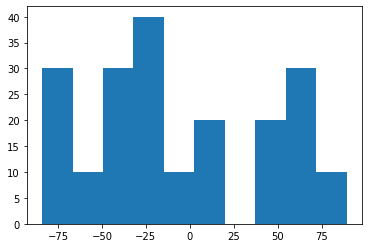

In [33]:
plt.hist(proton_caf["v_theta_xz"])

In [9]:
proton_keys = proton_file.keys()
dec_names = fnmatch.filter(proton_keys, '*run_*_sub_*_evt_*_decon*')
sim_names = fnmatch.filter(proton_keys, '*run_*_sub_*_evt_*_sim*')

(array([20., 10.,  0.,  0.,  0., 40.,  0.,  0., 20.,  0.,  0., 10.,  0.,
        20.,  0.,  0., 10., 10.,  0., 10.,  0., 10., 20.,  0.,  0.,  0.,
        10.,  0.,  0., 10.]),
 array([ 5.0306087,  7.573739 , 10.116869 , 12.66     , 15.20313  ,
        17.74626  , 20.28939  , 22.83252  , 25.37565  , 27.918781 ,
        30.46191  , 33.005043 , 35.548172 , 38.0913   , 40.634434 ,
        43.177563 , 45.72069  , 48.263824 , 50.806953 , 53.350082 ,
        55.893215 , 58.436344 , 60.979473 , 63.522606 , 66.065735 ,
        68.608864 , 71.15199  , 73.69512  , 76.23826  , 78.78139  ,
        81.32452  ], dtype=float32),
 <BarContainer object of 30 artists>)

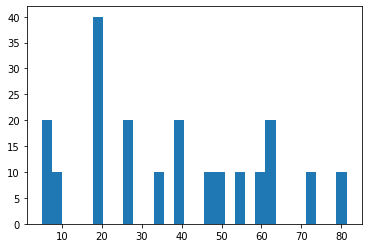

In [307]:
plt.hist(proton_caf.theta_xz,bins=30)

In [10]:
# for evtNum in tqdm(range(len(dec_names))):
u_proton_sim_arr = []
u_proton_dec_arr = []
v_proton_sim_arr = []
v_proton_dec_arr = []
w_proton_sim_arr = []
w_proton_dec_arr = []

u_proton_angle_arr  = []
u_proton_energy_arr = []
v_proton_angle_arr  = []
v_proton_energy_arr = []
w_proton_angle_arr  = []
w_proton_energy_arr = []
# for evtNum in tqdm(range(0,20)):
for evtNum in tqdm(range(100)):
    proton_evt_sim = proton_file[sim_names[evtNum]].values()
    proton_evt_dec = proton_file[dec_names[evtNum]].values()*50
    nonZeroCh = find_nonzero_ch(proton_evt_sim)
    for idx, i in enumerate(nonZeroCh):
        proton_wvfm_dec = proton_file[dec_names[evtNum]].values()[i]*50 # have to re-add the scaling factor
        proton_wvfm_sim = proton_file[sim_names[evtNum]].values()[i]
        sim_out = find_peaks(proton_wvfm_sim, height=50,threshold=0,prominence=0,width=5)
        # dec_out = find_peaks(proton_wvfm_dec, height=50,threshold=5,prominence=0,width=15)
        if len(sim_out[0]) > 1:
            # print("found two peaks")
            continue
        if len(sim_out[0]) == 1:
            right_side = sim_out[1]["right_bases"][0] + 100
            left_side = sim_out[1]["left_bases"][0] - 100
            if find_u_ch(i):
                u_proton_sim_arr.append(np.sum(proton_wvfm_sim))
                u_proton_dec_arr.append(np.sum(proton_wvfm_dec[left_side:right_side]))
                u_proton_angle_arr.append(proton_caf.iloc[evtNum].u_theta_xz)
                u_proton_energy_arr.append(proton_caf.iloc[evtNum].depE)  
            if find_v_ch(i):
                v_proton_sim_arr.append(np.sum(proton_wvfm_sim))
                v_proton_dec_arr.append(np.sum(proton_wvfm_dec[left_side:right_side]))
                v_proton_angle_arr.append(proton_caf.iloc[evtNum].v_theta_xz)
                v_proton_energy_arr.append(proton_caf.iloc[evtNum].depE)  
            if find_w_ch(i):
                w_proton_sim_arr.append(np.sum(proton_wvfm_sim))
                w_proton_dec_arr.append(np.sum(proton_wvfm_dec[left_side:right_side]))
                w_proton_angle_arr.append(proton_caf.iloc[evtNum].theta_xz)
                w_proton_energy_arr.append(proton_caf.iloc[evtNum].depE)  


100%|██████████| 100/100 [02:42<00:00,  1.63s/it]


In [11]:
u_proton_sim_arr = np.array(u_proton_sim_arr)
u_proton_dec_arr = np.array(u_proton_dec_arr)
v_proton_sim_arr = np.array(v_proton_sim_arr)
v_proton_dec_arr = np.array(v_proton_dec_arr)
w_proton_sim_arr = np.array(w_proton_sim_arr)
w_proton_dec_arr = np.array(w_proton_dec_arr)
u_proton_angle_arr =  np.array(u_proton_angle_arr)
u_proton_energy_arr = np.array(u_proton_energy_arr)
v_proton_angle_arr =  np.array(v_proton_angle_arr)
v_proton_energy_arr = np.array(v_proton_energy_arr)
w_proton_angle_arr =  np.array(w_proton_angle_arr)
w_proton_energy_arr = np.array(w_proton_energy_arr)

u_proton_diff_arr = (u_proton_dec_arr - u_proton_sim_arr)/u_proton_sim_arr 
v_proton_diff_arr = (v_proton_dec_arr - v_proton_sim_arr)/v_proton_sim_arr 
w_proton_diff_arr = (w_proton_dec_arr - w_proton_sim_arr)/w_proton_sim_arr 


In [12]:
ticks= [0,5,10,20,30,40,50,60,70,80,85]
binned_arr = [[], [], []]
for plane, plane_arr in enumerate(binned_arr):
    if plane == 0: 
        arr = u_proton_diff_arr
        angle_arr = u_proton_angle_arr
    if plane == 1: 
        arr = v_proton_diff_arr
        angle_arr = v_proton_angle_arr
    if plane == 2:
        arr = w_proton_diff_arr
        angle_arr = w_proton_angle_arr
    for i in range(len(ticks) - 1):
        lower = ticks[i]
        upper = ticks[i+1]
        mask = np.where((abs(arr)<1) & ( angle_arr >= lower) & ( angle_arr < upper),True,False)
        plane_arr.append(arr[mask])
        
u_mean = np.zeros(10)
v_mean = np.zeros(10)
w_mean = np.zeros(10)

u_stdd = np.zeros(10)
v_stdd = np.zeros(10)
w_stdd = np.zeros(10)

for i in range(len(ticks) - 1):
    if len(binned_arr[0][i]) > 100:
        u_mean[i] = np.mean(binned_arr[0][i])
        u_stdd[i] = np.std(binned_arr[0][i])
    if len(binned_arr[1][i]) > 100:
        v_mean[i] = np.mean(binned_arr[1][i])
        v_stdd[i] = np.std(binned_arr[1][i])
    if len(binned_arr[2][i]) > 100:
        w_mean[i] = np.mean(binned_arr[2][i])
        w_stdd[i] = np.std(binned_arr[2][i])

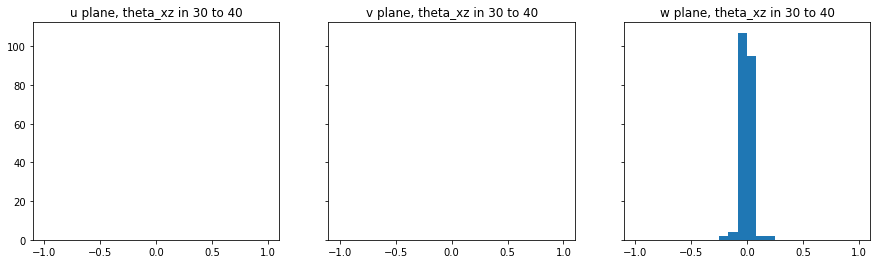

In [38]:
fig, axes = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)
angle_bin = 4
axes[0].hist(binned_arr[0][angle_bin],bins=np.linspace(-1,1,25))
axes[0].set_title(f"u plane, theta_xz in {ticks[angle_bin]} to {ticks[angle_bin+1]}")

axes[1].hist(binned_arr[1][angle_bin],bins=np.linspace(-1,1,25))
axes[1].set_title(f"v plane, theta_xz in {ticks[angle_bin]} to {ticks[angle_bin+1]}")

axes[2].hist(binned_arr[2][angle_bin],bins=np.linspace(-1,1,25))
axes[2].set_title(f"w plane, theta_xz in {ticks[angle_bin]} to {ticks[angle_bin+1]}")
plt.show()

In [26]:
print("u mean", repr(u_mean))
print("u stdd", repr(u_stdd))
print("--------")
print("v mean", repr(v_mean))
print("v stdd", repr(v_stdd))
print("--------")
print("w mean", repr(w_mean))
print("w stdd", repr(w_stdd))
print("--------")

u mean array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.00854625,  0.        , -0.041659  ,  0.        , -0.00177443])
u stdd array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06017283, 0.        , 0.04988726, 0.        , 0.02669963])
--------
v mean array([ 0.        ,  0.        ,  0.        ,  0.00407831,  0.        ,
        0.        , -0.00172148,  0.        ,  0.        ,  0.        ])
v stdd array([0.        , 0.        , 0.        , 0.04866043, 0.        ,
       0.        , 0.03837701, 0.        , 0.        , 0.        ])
--------
w mean array([ 0.        ,  0.        ,  0.        ,  0.        , -0.00253602,
       -0.0033589 ,  0.        ,  0.00652845, -0.00078769,  0.        ])
w stdd array([0.        , 0.        , 0.        , 0.        , 0.04684606,
       0.00629148, 0.        , 0.00751195, 0.00725527, 0.        ])
--------


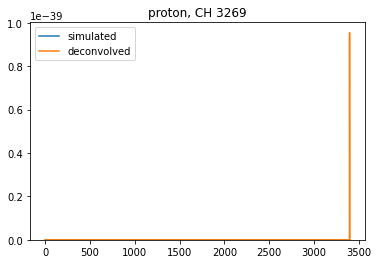

In [81]:
# hep.histplot(proton_file[sim_names[18]].values()[3266]   ,label="simulated")
# hep.histplot(proton_file[dec_names[18]].values()[3266]*50,label="deconvolved")
# plt.legend()
# # plt.xlim(900,1300)
# plt.title("proton, CH 3269")
# plt.show()

/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/mplhep/plot.py:482: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = ax.pcolormesh(X, Y, H, **kwargs)


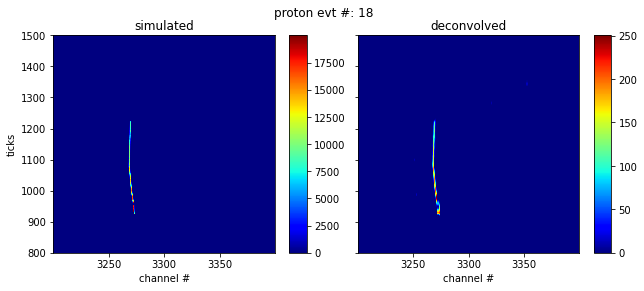

In [114]:
proton_evt_sim = proton_file[sim_names[18]].to_numpy()
proton_evt_dec = proton_file[dec_names[18]].to_numpy()*50

ch_min = 3200
ch_max = 3400

mask = np.where((abs(np.ceil(proton_evt_sim[1]))[:-1]<ch_max) & (abs(np.ceil(proton_evt_sim[1]))[:-1] >= ch_min), True,False)
xbins = proton_evt_sim[1][(proton_evt_sim[1]<ch_max) & (proton_evt_sim[1] >= ch_min)]
ybins = proton_evt_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
hep.hist2dplot(H=proton_evt_sim[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[0],cmap="jet",cmin=-1e3,cmax=2e4,)
hep.hist2dplot(H=proton_evt_dec[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[1],cmap="jet",cmin=-10,cmax=1e4,)
axes[0].set_ylim(800,1500)
axes[0].set_xlabel("channel #")
axes[1].set_xlabel("channel #")
axes[0].set_ylabel("ticks")
axes[0].set_title("simulated")
axes[1].set_title("deconvolved")
plt.suptitle(f"proton evt #: 18")
plt.show()

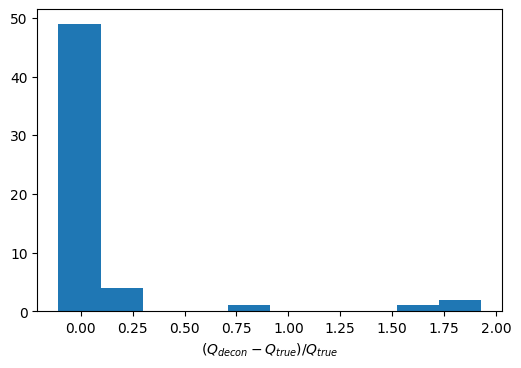

In [31]:
plt.figure(dpi=100)
plt.hist((dec_sum_arr - sim_sum_arr)/sim_sum_arr)
plt.xlabel("$(Q_{decon} - Q_{true}) / Q_{true}$")
plt.show()

In [19]:
np.where((dec_sum_arr - sim_sum_arr)/sim_sum_arr > 2)

(array([0]),)

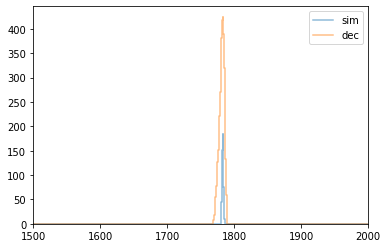

In [26]:
chNum = nonZeroCh[0]
proton_dec = proton_file[dec_names[evtNum]].values()[chNum]*50 # have to re-add the scaling factor
proton_sim = proton_file[sim_names[evtNum]].values()[chNum]

hep.histplot(proton_sim,alpha=0.5,label="sim")
hep.histplot(proton_dec,alpha=0.5,label="dec")
plt.legend()
plt.xlim(1500,2000)
plt.show()

## Electron

In [42]:
# caf_electron = uproot.open("/sbnd/app/users/lynnt/my_larsoft/v09_75_03/electron/electron_caf_electron.flat.caf.root:recTree")
# ana_electron = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_caf/ana_caf.root:recTree")
ana_electron = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_caf/test_caf.root:recTree")
electron_caf = ana_electron.arrays(["rec.hdr.run","rec.hdr.subrun","rec.hdr.evt",
                            # "rec.mc.nu.prim.start.x","rec.mc.nu.prim.end.x",
                            # "rec.mc.nu.prim.start.z","rec.mc.nu.prim.end.z",
                            "rec.mc.nu.prim.startp.x","rec.mc.nu.prim.startp.y","rec.mc.nu.prim.startp.z",
                            "rec.mc.nu.prim.startE","rec.mc.nu.prim.endE"],library='pd')
electron_caf["startp"] = np.sqrt(electron_caf["rec.mc.nu.prim.startp.x"]**2 + electron_caf["rec.mc.nu.prim.startp.y"]**2 + electron_caf["rec.mc.nu.prim.startp.z"]**2)
electron_caf["theta_xz"] = np.arctan(abs(electron_caf["rec.mc.nu.prim.startp.x"])/abs(electron_caf["rec.mc.nu.prim.startp.z"]))*(180/np.pi)
electron_caf["theta_yz"] = np.arctan((electron_caf["rec.mc.nu.prim.startp.z"])/(electron_caf["rec.mc.nu.prim.startp.y"]))*(180/np.pi)
# electron_caf["theta_xz"] = np.arctan(abs(electron_caf["rec.mc.nu.prim.start.x"] - electron_caf["rec.mc.nu.prim.end.x"])/abs(electron_caf["rec.mc.nu.prim.start.z"] - electron_caf["rec.mc.nu.prim.end.z"]))*(180/np.pi)
electron_caf["depE"] = electron_caf["rec.mc.nu.prim.startE"] - electron_caf["rec.mc.nu.prim.endE"]

electron_caf["v_pz"] = electron_caf.startp*np.sin((electron_caf.theta_yz - 60)*(np.pi/180)) # change units inside sin from degree to rad
electron_caf["u_pz"] = electron_caf.startp*np.sin((electron_caf.theta_yz + 60)*(np.pi/180)) # change units inside sin from degree to rad

electron_caf["u_theta_xz"] = np.arctan(abs(electron_caf["rec.mc.nu.prim.startp.x"])/abs(electron_caf["u_pz"]))*(180/np.pi)
electron_caf["v_theta_xz"] = np.arctan(abs(electron_caf["rec.mc.nu.prim.startp.x"])/abs(electron_caf["v_pz"]))*(180/np.pi)

In [191]:
# list_of_dicts = []
# with open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_wvfm/waveform.list") as f:
#     mylist = f.read().splitlines()
#     for i in tqdm(mylist):
#         list_of_dicts.append(uproot.open(i+":wvfm_tree").arrays(library="np"))
        
# result = {}
# for key in list_of_dicts[0]:
#     result[key] = np.concatenate([d[key] for d in list_of_dicts])

  0%|          | 0/497 [00:00<?, ?it/s]

100%|██████████| 497/497 [06:07<00:00,  1.35it/s]


In [208]:
# # with open('electron_wvfmtree.pkl', 'wb') as f:
# #     pkl.dump(result, f)

# path_to_wvfm = "/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_wvfm/ana_waveform_9.root"
# electron_tree = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_wvfm/ana_waveform_9.root:wvfm_tree").arrays(library='np')

In [44]:
f = open('electron_wvfmtree.pkl', 'rb')
electron_tree = pkl.load(f)   

In [45]:
# electron_file = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_wvfm/ana_waveform_9.root")
# electron_keys = electron_file.keys()
# electron_tree = uproot.open("/pnfs/sbnd/scratch/users/lynnt/v09_75_03/ep_validation/electron_wvfm/ana_waveform_9.root:wvfm_tree").arrays(library='np')
# electron_dec_names = fnmatch.filter(electron_keys, '*run_*_sub_*_event_*_decon*')
# electron_sim_names = fnmatch.filter(electron_keys, '*run_*_sub_*_event_*_sim*')
# electron_tree = result
sim_sum_arr = []
dec_sum_arr = []

u_sim_sum_arr = []
u_dec_sum_arr = []

v_sim_sum_arr = []
v_dec_sum_arr = []

w_sim_sum_arr = []
w_dec_sum_arr = []

theta_xz_arr = []
u_theta_xz_arr = []
v_theta_xz_arr = []
w_theta_xz_arr = []

depE_arr = []

for event in tqdm(range(len(electron_tree['run']))):
# for event in tqdm(range(20)):
    # sim_wvfm = electron_file[electron_sim_names[event]].values()
    # nonZeroCh_e = find_nonzero_ch(sim_wvfm)
    # print("Number of NonZero channels:", len(nonZeroCh_e))
    
    # for idx, i in enumerate(nonZeroCh_e):
    #     sim_sum_arr[event] += (np.sum(electron_tree["sim_sum"][event][i]))
    #     dec_sum_arr[event] += (np.sum(electron_tree["decon_sum"][event][i])*50)
    run = electron_tree["run"][event]
    sub = electron_tree["sub"][event]
    evt = electron_tree["evt"][event]
    
    cut_caf = electron_caf[(electron_caf["rec.hdr.evt"] == evt) & (electron_caf["rec.hdr.subrun"] == sub) & (electron_caf["rec.hdr.run"] == run)]
    if (len(cut_caf) == 0):
        continue
    else:
        sim_sum_arr.append((np.sum(electron_tree["sim_sum"][event])))
        dec_sum_arr.append((np.sum(electron_tree["decon_sum"][event])*50))
        u_sim_sum_arr.append((np.sum(u_ch(electron_tree["sim_sum"][event]))))
        u_dec_sum_arr.append((np.sum(u_ch(electron_tree["decon_sum"][event])*50)))
        v_sim_sum_arr.append((np.sum(v_ch(electron_tree["sim_sum"][event]))))
        v_dec_sum_arr.append((np.sum(v_ch(electron_tree["decon_sum"][event])*50)))
        w_sim_sum_arr.append((np.sum(w_ch(electron_tree["sim_sum"][event]))))
        w_dec_sum_arr.append((np.sum(w_ch(electron_tree["decon_sum"][event])*50)))
        theta_xz_arr.append((cut_caf.iloc[0].theta_xz))
        u_theta_xz_arr.append((cut_caf.iloc[0].u_theta_xz))
        v_theta_xz_arr.append((cut_caf.iloc[0].v_theta_xz))
        w_theta_xz_arr.append((cut_caf.iloc[0].theta_xz))

        depE_arr.append((cut_caf.iloc[0].depE))
    
sim_sum_arr = np.array(sim_sum_arr)
dec_sum_arr = np.array(dec_sum_arr)
u_sim_sum_arr = np.array(u_sim_sum_arr)
u_dec_sum_arr = np.array(u_dec_sum_arr)
v_sim_sum_arr = np.array(v_sim_sum_arr)
v_dec_sum_arr = np.array(v_dec_sum_arr)
w_sim_sum_arr = np.array(w_sim_sum_arr)
w_dec_sum_arr = np.array(w_dec_sum_arr)
theta_xz_arr = np.array(theta_xz_arr)
depE_arr = np.array(depE_arr)
electron_diff_arr = (dec_sum_arr-sim_sum_arr)/sim_sum_arr
u_electron_diff_arr = (u_dec_sum_arr-u_sim_sum_arr)/u_sim_sum_arr
v_electron_diff_arr = (v_dec_sum_arr-v_sim_sum_arr)/v_sim_sum_arr
w_electron_diff_arr = (w_dec_sum_arr-w_sim_sum_arr)/w_sim_sum_arr

 25%|██▍       | 2462/9940 [00:16<00:46, 160.53it/s]/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
100%|██████████| 9940/9940 [01:04<00:00, 154.97it/s]
/sbnd/app/users/lynnt/.venv/lib64/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide


In [46]:
u_theta_xz_arr = np.array(u_theta_xz_arr)
v_theta_xz_arr = np.array(v_theta_xz_arr)
w_theta_xz_arr = np.array(w_theta_xz_arr)

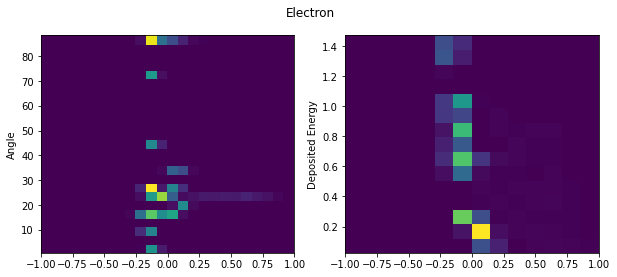

In [47]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
axes[0].hist2d(electron_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,25),25])
axes[1].hist2d(electron_diff_arr,depE_arr,    bins=[np.linspace(-1,1,15),15])

axes[0].set_ylabel("Angle")
axes[1].set_ylabel("Deposited Energy")
plt.suptitle("Electron")
plt.show()

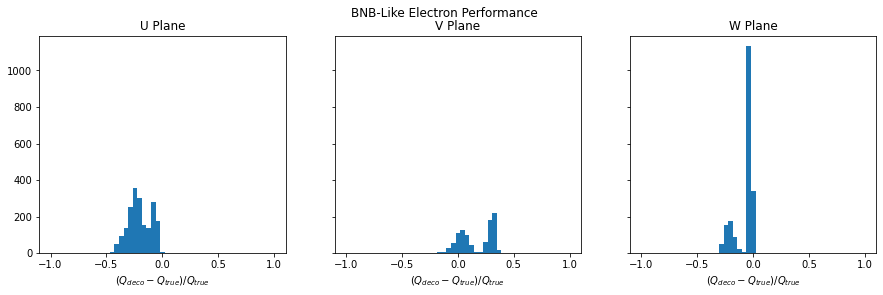

u mean:  -0.20305982
u stdd:  0.09939985
v mean:  0.16556925
v stdd:  0.14990678
w mean:  -0.07142552
w stdd:  0.085950986


In [48]:
u_mask = np.where(((u_theta_xz_arr >= 10) & (u_theta_xz_arr < 20)) & (abs(u_electron_diff_arr) < 1) ,True,False)
v_mask = np.where(((v_theta_xz_arr >= 10) & (v_theta_xz_arr < 20)) & (abs(v_electron_diff_arr) < 1) ,True,False)
w_mask = np.where(((w_theta_xz_arr >= 10) & (w_theta_xz_arr < 20)) & (abs(w_electron_diff_arr) < 1) ,True,False)

fig, axes = plt.subplots(1,3,figsize=(15,4),sharey=True)
axes[0].hist(u_electron_diff_arr[u_mask],bins=np.linspace(-1,1))
axes[1].hist(v_electron_diff_arr[v_mask],bins=np.linspace(-1,1))
axes[2].hist(w_electron_diff_arr[w_mask],bins=np.linspace(-1,1))

axes[0].set_title("U Plane")
axes[1].set_title("V Plane")
axes[2].set_title("W Plane")

axes[0].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[1].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[2].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")

plt.suptitle("BNB-Like Electron Performance")
plt.show()
print("u mean: ", np.mean(u_electron_diff_arr[u_mask]))
print("u stdd: ", np.std(u_electron_diff_arr[u_mask]))
print("v mean: ", np.mean(v_electron_diff_arr[v_mask]))
print("v stdd: ", np.std(v_electron_diff_arr[v_mask]))
print("w mean: ", np.mean(w_electron_diff_arr[w_mask]))
print("w stdd: ", np.std(w_electron_diff_arr[w_mask]))

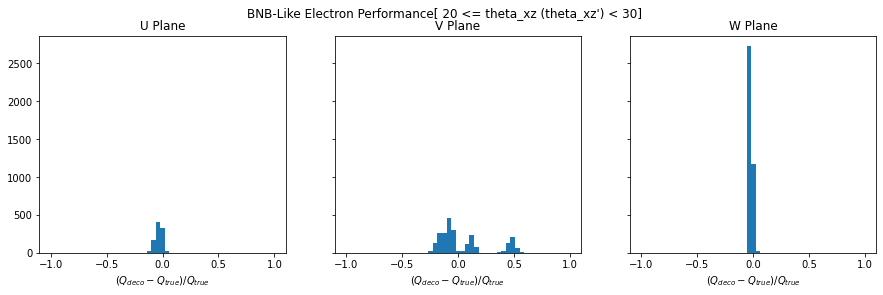

u mean:  -0.03438462
u stdd:  0.04633841
v mean:  0.052879896
v stdd:  0.23476808
w mean:  -0.022671646
w stdd:  0.0109035075


In [36]:
u_mask = np.where(((u_theta_xz_arr >= 20) & (u_theta_xz_arr < 30)) & (abs(u_electron_diff_arr) < 1) ,True,False)
v_mask = np.where(((v_theta_xz_arr >= 20) & (v_theta_xz_arr < 30)) & (abs(v_electron_diff_arr) < 1) ,True,False)
w_mask = np.where(((w_theta_xz_arr >= 20) & (w_theta_xz_arr < 30)) & (abs(w_electron_diff_arr) < 1) ,True,False)

fig, axes = plt.subplots(1,3,figsize=(15,4),sharey=True)
axes[0].hist(u_electron_diff_arr[u_mask],bins=np.linspace(-1,1))
axes[1].hist(v_electron_diff_arr[v_mask],bins=np.linspace(-1,1))
axes[2].hist(w_electron_diff_arr[w_mask],bins=np.linspace(-1,1))

axes[0].set_title("U Plane")
axes[1].set_title("V Plane")
axes[2].set_title("W Plane")

axes[0].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[1].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[2].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")

plt.suptitle("BNB-Like Electron Performance[ 20 <= theta_xz (theta_xz') < 30]")
plt.show()
print("u mean: ", np.mean(u_electron_diff_arr[u_mask]))
print("u stdd: ", np.std(u_electron_diff_arr[u_mask]))
print("v mean: ", np.mean(v_electron_diff_arr[v_mask]))
print("v stdd: ", np.std(v_electron_diff_arr[v_mask]))
print("w mean: ", np.mean(w_electron_diff_arr[w_mask]))
print("w stdd: ", np.std(w_electron_diff_arr[w_mask]))

In [49]:

        
u_mean = np.zeros(10)
v_mean = np.zeros(10)
w_mean = np.zeros(10)

u_stdd = np.zeros(10)
v_stdd = np.zeros(10)
w_stdd = np.zeros(10)

for i in range(len(ticks) - 1):
    if len(binned_arr[0][i]) > 100:
        u_mean[i] = np.mean(binned_arr[0][i])
        u_stdd[i] = np.std(binned_arr[0][i])
    if len(binned_arr[1][i]) > 100:
        v_mean[i] = np.mean(binned_arr[1][i])
        v_stdd[i] = np.std(binned_arr[1][i])
    if len(binned_arr[2][i]) > 100:
        w_mean[i] = np.mean(binned_arr[2][i])
        w_stdd[i] = np.std(binned_arr[2][i])

In [50]:
print("u mean", repr(u_mean))
print("u stdd", repr(u_stdd))
print("--------")
print("v mean", repr(v_mean))
print("v stdd", repr(v_stdd))
print("--------")
print("w mean", repr(w_mean))
print("w stdd", repr(w_stdd))
print("--------")

u mean array([-0.27730048,  0.        , -0.20305982, -0.03438462, -0.11447691,
       -0.15884794, -0.14844562, -0.06711978, -0.22091414,  0.        ])
u stdd array([0.05754266, 0.        , 0.09939985, 0.04633841, 0.10253054,
       0.09752367, 0.05132978, 0.06382533, 0.09384432, 0.        ])
--------
v mean array([ 0.        ,  0.0721661 ,  0.16556925,  0.0528799 , -0.00522415,
       -0.00227395, -0.13205793,  0.24688123,  0.        , -0.04082272])
v stdd array([0.        , 0.04344897, 0.14990678, 0.23476808, 0.16946904,
       0.27486363, 0.05343102, 0.06483078, 0.        , 0.02959644])
--------
w mean array([-0.03230978, -0.04051084, -0.07142552, -0.02267165, -0.02389131,
       -0.02382215,  0.        ,  0.        , -0.03909435,  0.        ])
w stdd array([0.00322721, 0.00231466, 0.08595099, 0.01090351, 0.04147356,
       0.00315664, 0.        , 0.        , 0.00518463, 0.        ])
--------


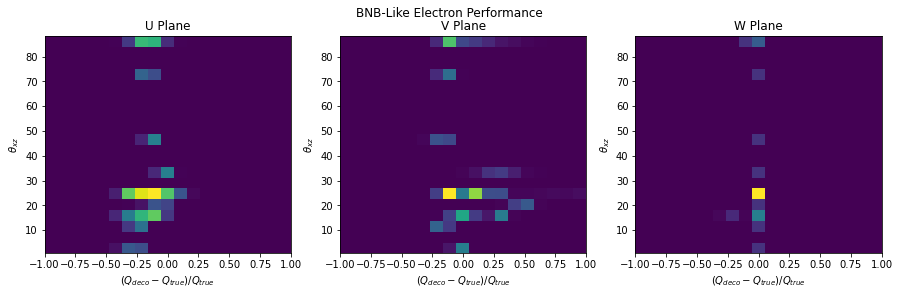

In [300]:
fig, axes = plt.subplots(1,3,figsize=(15,4))
axes[0].hist2d(u_electron_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,20),20])
axes[1].hist2d(v_electron_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,20),20])
axes[2].hist2d(w_electron_diff_arr,theta_xz_arr,bins=[np.linspace(-1,1,20),20])

axes[0].set_title("U Plane")
axes[1].set_title("V Plane")
axes[2].set_title("W Plane")

axes[0].set_ylabel(r"$\theta_{xz}$")
axes[1].set_ylabel(r"$\theta_{xz}$")
axes[2].set_ylabel(r"$\theta_{xz}$")

axes[0].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[1].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")
axes[2].set_xlabel("$(Q_{deco}-Q_{true})/Q_{true}$")

plt.suptitle("BNB-Like Electron Performance")
plt.show()

(array([ 493.,    0.,  493., 1972.,  493., 3451.,    0.,  493.,    0.,
           0.,  493.,    0.,    0.,    0.,    0.,    0.,  493.,    0.,
           0., 1479.]),
 array([ 0.67327219,  5.060034  ,  9.4467958 , 13.83355761, 18.22031941,
        22.60708122, 26.99384302, 31.38060483, 35.76736664, 40.15412844,
        44.54089025, 48.92765205, 53.31441386, 57.70117566, 62.08793747,
        66.47469927, 70.86146108, 75.24822288, 79.63498469, 84.0217465 ,
        88.4085083 ]),
 <BarContainer object of 20 artists>)

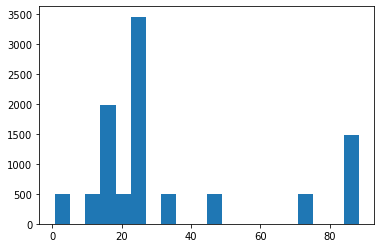

In [304]:
plt.hist(theta_xz_arr,bins=20)

In [39]:
electron_evt_sim = electron_file[electron_sim_names[73]].to_numpy()
electron_evt_dec = electron_file[electron_dec_names[73]].to_numpy()*50

ch_min = idx_w0
ch_max = idx_u1

mask = np.where((abs(np.ceil(electron_evt_sim[1]))[:-1]<ch_max) & (abs(np.ceil(electron_evt_sim[1]))[:-1] >= ch_min), True,False)
xbins = electron_evt_sim[1][(electron_evt_sim[1]<ch_max) & (electron_evt_sim[1] >= ch_min)]
ybins = electron_evt_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
hep.hist2dplot(H=electron_evt_sim[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[0],cmap="jet",cmin=-1e3,cmax=2e4,)
hep.hist2dplot(H=electron_evt_dec[0][:][mask]*50,xbins=xbins,ybins=ybins,shading="auto",ax=axes[1],cmap="jet",cmin=-10,cmax=2e4,)
axes[0].set_ylim(800,1500)
axes[0].set_xlabel("channel #")
axes[1].set_xlabel("channel #")
axes[0].set_ylabel("ticks")
axes[0].set_title("simulated")
axes[1].set_title("deconvolved")
plt.suptitle("electron evt #: 18")
plt.show()

NameError: name 'electron_file' is not defined

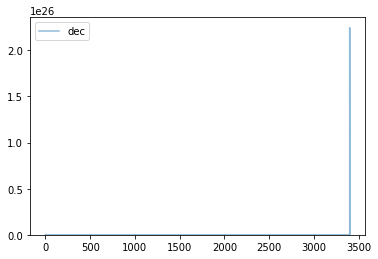

In [174]:
sim_wvfm = electron_file[electron_sim_names[73]].values()
nonZeroCh_e = find_nonzero_ch(sim_wvfm)
chNum = 1
# chNum = nonZeroCh[2]
electron_dec = electron_file[electron_dec_names[73]].values()[chNum]*50 # have to re-add the scaling factor
electron_sim = electron_file[electron_sim_names[73]].values()[chNum]

# hep.histplot(electron_sim,alpha=0.5,label="sim")
hep.histplot(electron_dec,alpha=0.5,label="dec")
plt.legend()
# plt.xlim(2600,3200)
plt.show()

for idx, i in enumerate(nonZeroCh_e):
    if (electron_tree["decon_sum"][73][i]*50)>5e5:
        print(i)

(array([1.1263e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([-3.1228577e+02,  2.2448581e+25,  4.4897161e+25,  6.7345742e+25,
         8.9794323e+25,  1.1224290e+26,  1.3469148e+26,  1.5714007e+26,
         1.7958865e+26,  2.0203723e+26,  2.2448581e+26], dtype=float32),
 <BarContainer object of 10 artists>)

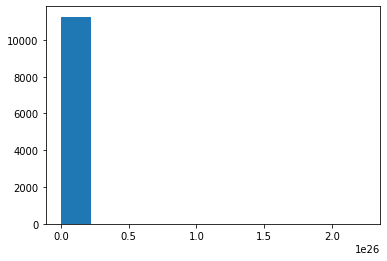

In [167]:
plt.hist(electron_tree["decon_sum"][73]*50)

In [170]:
electron_tree["decon_sum"][73]

array([-6.2457156e+00,  4.4897161e+24,  1.9080080e-41, ...,
        1.9080080e-41,  1.9080080e-41,  1.9080080e-41], dtype=float32)

In [169]:
np.where(electron_tree["decon_sum"][73]*50 > 1e10)

(array([1]),)

(array([1.1136e+04, 7.5000e+01, 2.5000e+01, 1.6000e+01, 6.0000e+00,
        2.0000e+00, 2.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([     0.  ,  44431.94,  88863.88, 133295.83, 177727.77, 222159.7 ,
        266591.66, 311023.6 , 355455.53, 399887.47, 444319.4 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

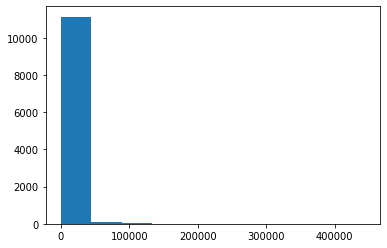

In [168]:
plt.hist(electron_tree["sim_sum"][73])

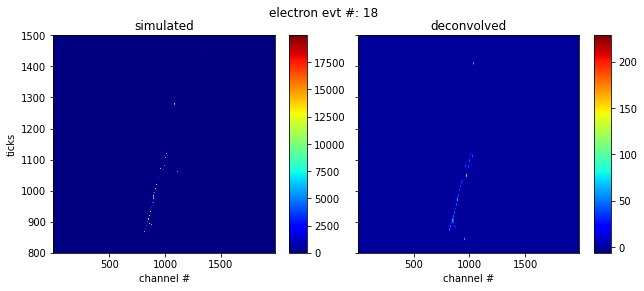

In [130]:
electron_evt_sim = electron_file[electron_sim_names[73]].to_numpy()
electron_evt_dec = electron_file[electron_dec_names[73]].to_numpy()*50

ch_min = idx_u0
ch_max = idx_v0

mask = np.where((abs(np.ceil(electron_evt_sim[1]))[:-1]<ch_max) & (abs(np.ceil(electron_evt_sim[1]))[:-1] >= ch_min), True,False)
xbins = electron_evt_sim[1][(electron_evt_sim[1]<ch_max) & (electron_evt_sim[1] >= ch_min)]
ybins = electron_evt_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
hep.hist2dplot(H=electron_evt_sim[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[0],cmap="jet",cmin=-1e3,cmax=2e4,)
hep.hist2dplot(H=electron_evt_dec[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[1],cmap="jet",cmin=-10,cmax=1e4,)
axes[0].set_ylim(800,1500)
axes[0].set_xlabel("channel #")
axes[1].set_xlabel("channel #")
axes[0].set_ylabel("ticks")
axes[0].set_title("simulated")
axes[1].set_title("deconvolved")
plt.suptitle("electron evt #: 18")
plt.show()

In [ ]:
electron_evt_sim = electron_file[electron_sim_names[73]].to_numpy()
electron_evt_dec = electron_file[electron_dec_names[73]].to_numpy()*50

ch_min = idx_u0
ch_max = idx_v0

mask = np.where((abs(np.ceil(electron_evt_sim[1]))[:-1]<ch_max) & (abs(np.ceil(electron_evt_sim[1]))[:-1] >= ch_min), True,False)
xbins = electron_evt_sim[1][(electron_evt_sim[1]<ch_max) & (electron_evt_sim[1] >= ch_min)]
ybins = electron_evt_sim[2]

fig, axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
hep.hist2dplot(H=electron_evt_sim[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[0],cmap="jet",cmin=-1e3,cmax=2e4,)
hep.hist2dplot(H=electron_evt_dec[0][:][mask],xbins=xbins,ybins=ybins,shading="auto",ax=axes[1],cmap="jet",cmin=-10,cmax=1e4,)
axes[0].set_ylim(800,1500)
axes[0].set_xlabel("channel #")
axes[1].set_xlabel("channel #")
axes[0].set_ylabel("ticks")
axes[0].set_title("simulated")
axes[1].set_title("deconvolved")
plt.suptitle("electron evt #: 18")
plt.show()